# Monte Carlo Method

In the [previous notebook](./valIt.ipynb), we have encountered value iteration as a simple and effective method to solve problems in reinforcement learning. However, as a model-based approach, it is only useful if a model for the transition probabilities is available.

In the present notebook, we encounter the **Monte Carlo Method** as a simple and powerful method in the context of **model-free methods**. That is, we directly learn an approximation of the value function from the observations. We first describe the concept behind this method before showing how it applies to the ``Frozen Lake`` testcase.

## Learning the Value Table

In essence, the Monte Carlo method relies on the observation that the value of a state can be estimated by averaging the  total rewards $\{R^{(n)}\}_{n \le N}$ defined via
$$R^{(n)} = r_0^{(n)} +  r_1^{(n)} + \cdots$$
over a large number of $N$ simulations. 

That is, when starting the simulation at a state $s$, we estimate
$$V(s) \approx \frac{R^{(1)} + \cdots + R^{(N)}}N.$$ 


In fact, we can increase the sample-efficiency by using a single run to update the value function of all states occurring along the run.

In [232]:
import gym

def episode(env = gym.make('FrozenLake-v0')):
    """Simulate one episode of the environment
    
    # Arguments
        env: environment for the problem
    # Result
        states visited and reward
    """

    R = 0
    s = env.reset()
    state_trace = [s]

    while True:
        (s, r, d, _) = env.step(np.random.choice(env.action_space.n))

        state_trace += [s]
        R += r

        if d: break
    return state_trace, R

Now, we estimate the value function from a large number of iterations.

In [233]:
import numpy as np

#number of episodes
neps = int(2e3)

rewards = np.zeros((env.nS, neps))
visits = np.zeros((env.nS, neps))

for i in range(neps):
    state_trace, R = episode()
    rewards[state_trace, i] = R
    visits[state_trace, i] = 1

# Visualization

A visualization reveals that the Monte Carlo methods leads to a rapid convergence of the state values.

/home/christian/.local/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


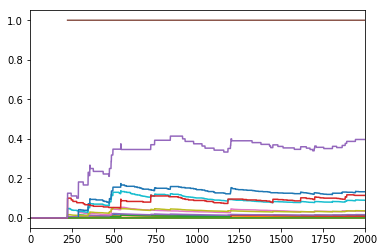

In [234]:
import pandas as pd
%matplotlib inline

r_trace = np.cumsum(rewards, 1) / np.cumsum(visits, 1)
df = pd.DataFrame(np.transpose(r_trace))
df.plot(legend = False)

## Learning the Optimal Policy

Now, we reproduce the [lucid notebook](https://github.com/jknthn/learning-rl/blob/master/monte-carlo-methods.ipynb) by Jeremi Kaczmarczyk to extract the optimal policy from MC estimates.

The central piece is the fitting of an $\varepsilon$-soft policy via Monte Carlo methods.

In [41]:
def monte_carlo_e_soft(env, 
                       neps = int(5e3), 
                       eps = 1e-2):
    """Fit an epsilon-soft policy via Monte Carlo
    
    # Arguments
        env: environment for the problem
        neps: number of episodes
        eps: fit eps-soft policy
    # Result
        fitted policy
    """
    
    #initialize Q-function and random policy
    policy = np.full((env.nS, env.nA), 1 / env.nA)
    Q = np.zeros((env.nS, env.nA))
    
    #rewards and visits to state action pairs
    rewards = np.zeros((env.nS, env.nA))
    visits = np.zeros((env.nS, env.nA))
    
    for _ in range(neps):
        #create episode
        G = 0 
        episode = run_game(env, policy) 
        
        for i in reversed(range(len(episode))):
            #accumulate rewards
            s, a, r = episode[i] 
            G += r 
            
            if not (s, a) in [(x[0], x[1]) for x in episode[:i]]: 
                #update rewards and visits
                rewards[s, a] += G
                visits[s, a] += 1
                
                #update Q-function
                Q[s, a] = rewards[s, a] / visits[s, a] 
                
                #eps-greedy policy
                max_idx = np.random.choice(np.where(Q[s, :] == max(Q[s, :]))[0])                
                policy[s, :] = eps / env.nA
                policy[s, max_idx] += 1 - eps
    return policy

During the fitting, we need to simulate an episode according to a given policy.

In [133]:
import numpy as np

def run_game(env, 
             policy):
    """Simulate one episode of the environment according to a given policy
    
    # Arguments
        env: environment for the problem
        policy: chosen policy
    # Result
        states visited and reward
    """
    s = env.reset()
    trace = []
    
    while True:      
        #select action according to policy
        a = np.random.choice(range(env.nA), p = policy[s, :])   
        ss, r, d, _ =  env.step(a)        
        
        #add observation to trace
        trace += [(s, a, r)]        
        s = ss
        
        #terminate 
        if d: break    
       
    return trace

Finally, we check how well the fitted method performs.

In [238]:
NTEST = int(1e3)

np.random.seed(seed)
policy = monte_carlo_e_soft(env)

wins = 0
for _ in range(NTEST):
    _, _, w = run_game(env, policy)[-1]
    wins += w
wins / NTEST

0.267